In [2]:
#Imports things that could be useful
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import seaborn as sb
from sklearn import preprocessing
import scipy.stats as stat
%matplotlib inline

In [3]:
#Imports training dataset, saves it in dfTraining variable
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0
client_0e13c2cd05114f26ab7cc32b4518509d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='gqp82oKkbpxFOo9MxyDOJmZM5hIUY7ky61NW33W7zt9Z',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_0e13c2cd05114f26ab7cc32b4518509d.get_object(Bucket='ds320-donotdelete-pr-egg8nb6d95qqxy',Key='Training.csv')['Body']

if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dfTraining = pd.read_csv(body)
dfTraining.head()


,season,conf,w,l,wl,w_conf,l_conf,wl_conf,srs,sos,...,seed,coaches,seeded,year,is_ap_pre,is_ap_high,is_ap_final,pts_diff,school,pts_total
0,2015-16,Southland,13,18,0.419,8,10,0.444,-13.93,-7.53,...,20,Joe Golding,False,2016,False,False,False,-2.0,abilene-christian,144.6
1,2014-15,Southland,10,21,0.323,4,14,0.222,-17.20,-6.34,...,20,Joe Golding,False,2015,False,False,False,-6.8,abilene-christian,134.2
2,2013-14,Southland,11,20,0.355,2,12,0.143,-19.60,-4.12,...,20,Joe Golding,False,2014,False,False,False,-0.5,abilene-christian,143.3
3,2015-16,MWC,14,18,0.438,5,13,0.278,-5.51,0.66,...,20,Dave Pilipovich,False,2016,False,False,False,-4.4,air-force,141.2
4,2014-15,MWC,14,17,0.452,6,12,0.333,-1.85,-0.71,...,20,Dave Pilipovich,False,2015,False,False,False,0.6,air-force,130.8


In [4]:
#Examines columns of dfTraining
dfTraining.columns

Index(['season', 'conf', 'w', 'l', 'wl', 'w_conf', 'l_conf', 'wl_conf', 'srs',
       'sos', 'pts', 'pts_vs', 'ap_pre', 'ap_high', 'ap_final',
       'ncaa_tournament', 'seed', 'coaches', 'seeded', 'year', 'is_ap_pre',
       'is_ap_high', 'is_ap_final', 'pts_diff', 'school', 'pts_total'],
      dtype='object')

In [5]:
#Drops unneccessary columns from dfTraining
#season and year were dropped because our test set will have different seasons/years than the training set.
#wins, losses, conference wins, and conference losses were considered unneccessary because all of the information they convey is contained in
#the win-loss% and conference win-loss% columns. Likewise, the point differential column conveys both points for and points against.
#Preseason AP rank, highest AP rank, and final AP rank were all dropped because they have corresponding true/false values that are easier to 
#use with our model. NCAA Tournament result and numerical seed aren't necessary because the "seeded" column tells us whether a team made the 
#tournament, which is all we need to know about the tournament.
#We removed coaches because although there are some famous coaches that would likely help a team make the tournament, these are far outnumbered
#by average coaches. In addition, the categorical nature of this column makes actually using its data incredibly difficult.
#Lastly, the is_ap_pre column (true/false value) was removed because because pre-season rankings are not always very accurate.

dfTraining = dfTraining.drop(columns=['season', 'w','l', 'w_conf','l_conf', 'pts', 'pts_vs', 'ap_pre','ap_high',
                         'ap_final','ncaa_tournament','seed','coaches','year','is_ap_pre',
                         'school','pts_total'])
dfTraining.columns

Index(['conf', 'wl', 'wl_conf', 'srs', 'sos', 'seeded', 'is_ap_high',
       'is_ap_final', 'pts_diff'],
      dtype='object')

In [6]:
#Checks for missing values
dfTraining.isnull().sum()

conf           0
wl             0
wl_conf        0
srs            0
sos            0
seeded         0
is_ap_high     0
is_ap_final    0
pts_diff       0
dtype: int64

In [7]:
#Describes the training data
dfTraining.describe(include='all')

,conf,wl,wl_conf,srs,sos,seeded,is_ap_high,is_ap_final,pts_diff
count,5411,5411.000000,5411.000000,5411.000000,5411.000000,5411,5411,5411,5411.000000
unique,38,NaN,NaN,NaN,NaN,2,2,2,NaN
top,Big East,NaN,NaN,NaN,NaN,False,False,False,NaN
freq,225,NaN,NaN,NaN,NaN,4353,4683,5010,NaN
mean,NaN,0.507075,0.491757,-0.718553,-0.310914,NaN,NaN,NaN,0.606653
std,NaN,0.175194,0.219962,10.076313,5.473243,NaN,NaN,NaN,6.290389
min,NaN,0.000000,0.000000,-35.850000,-15.810000,NaN,NaN,NaN,-26.700000
25%,NaN,0.387000,0.333000,-7.880000,-4.470000,NaN,NaN,NaN,-3.600000
50%,NaN,0.515000,0.500000,-1.600000,-1.111941,NaN,NaN,NaN,0.700000
75%,NaN,0.636000,0.667000,6.315000,4.240000,NaN,NaN,NaN,4.900000


In [8]:
#Displays the info about the dfTraining variable
dfTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   conf         5411 non-null   object 
 1   wl           5411 non-null   float64
 2   wl_conf      5411 non-null   float64
 3   srs          5411 non-null   float64
 4   sos          5411 non-null   float64
 5   seeded       5411 non-null   bool   
 6   is_ap_high   5411 non-null   bool   
 7   is_ap_final  5411 non-null   bool   
 8   pts_diff     5411 non-null   float64
dtypes: bool(3), float64(5), object(1)
memory usage: 269.6+ KB


Text(0, 0.5, 'Count of Teams')

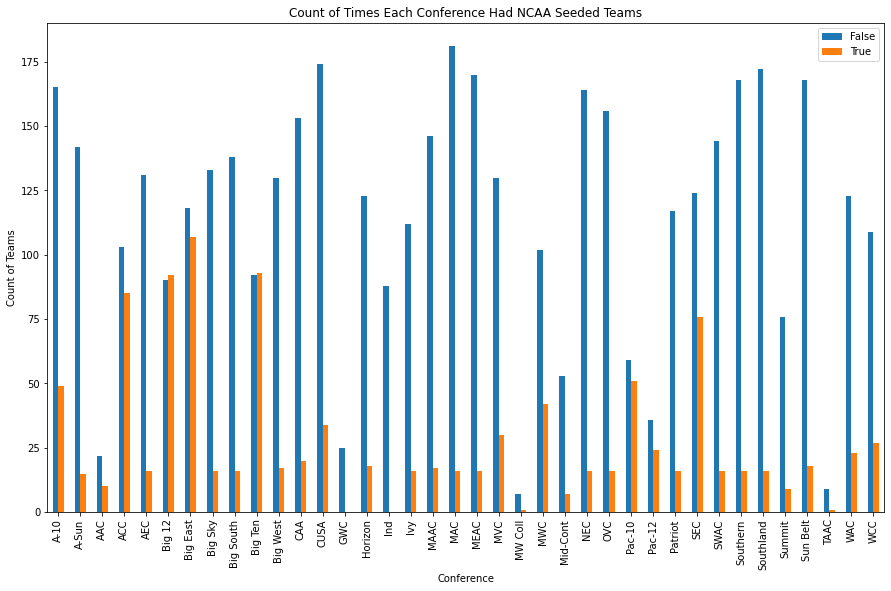

In [9]:
#Creates bar graph to display the number of seeded/non-seeded teams
#from each conference as found in dfTraining
graph1 = dfTraining.pivot_table(index="conf", columns="seeded", aggfunc="count", fill_value=0)
graph1 = graph1.iloc[:, : 2]
graph1.columns = [''] * len(graph1.columns)
graph1.columns = ["False", "True"]
graph1.plot(kind='bar', figsize=(15, 9))

plt.title("Count of Times Each Conference Had NCAA Seeded Teams")
plt.xlabel("Conference")
plt.ylabel("Count of Teams")
#This graph shows that some conferences have had many more teams make 
#NCAA Tournament appearances than other teams. This also tells us that it is 
#important to factor in a team's conference into our model.

Text(0, 0.5, 'Average Win Loss %')

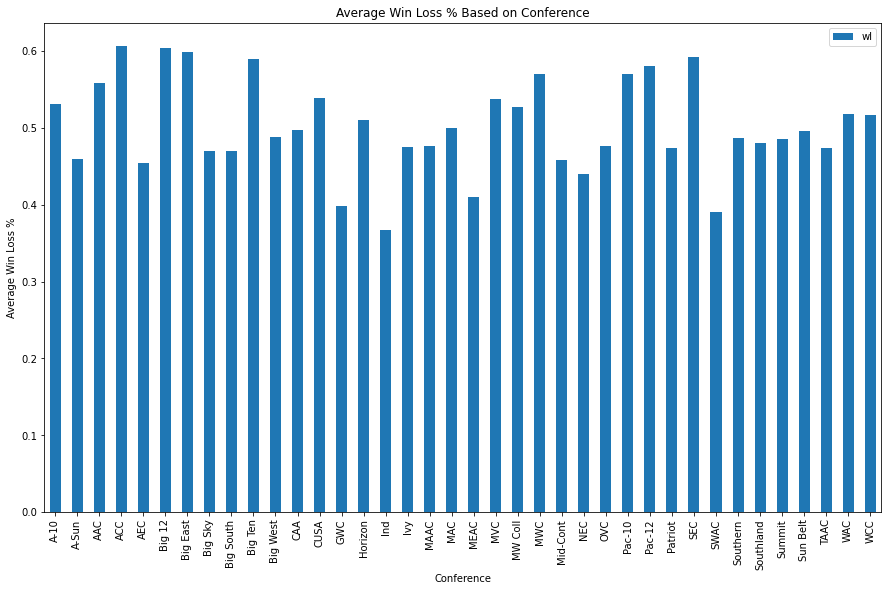

In [10]:
#We wanted to create a graph that would show us the win loss percentages based on conference
#began by creating a series with just the conference and win-loss % columns, then grouped by conf and took the mean
#this step allowed us to be able to get the average win loss % of each conference
#We then took thus data and put it on a bar graph. 
group = dfTraining[['conf','wl']]
graph2=group.groupby("conf").mean() 
graph2.plot(kind='bar', figsize=(15, 9))

plt.title("Average Win Loss % Based on Conference")
plt.xlabel("Conference")
plt.ylabel("Average Win Loss %")

#analyzing the results of this graph, we can see that the Ind, CUSA, and SWAC have the lowest average win loss %, and ACC,Big 12, and Big East have the highest average win loss %. 
#comparing this to our previous graph, we see that the Ind, CUSA, and SWAC all have very low counts of teams that showed seeded = True, which correlates with the conference having a low w/l %
#we can also see that ACC, Big 12, and Big East are all in the top 4 for highest count of seeded = True, which also correlates with their high average win-loss %

In [11]:
#Imports data to use for line graph, saves it in variable line_graph_data
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

client_0e13c2cd05114f26ab7cc32b4518509d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='gqp82oKkbpxFOo9MxyDOJmZM5hIUY7ky61NW33W7zt9Z',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_0e13c2cd05114f26ab7cc32b4518509d.get_object(Bucket='ds320-donotdelete-pr-egg8nb6d95qqxy',Key='ncaa-team-data.csv')['Body']

if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

line_graph_data = pd.read_csv(body)
line_graph_data.head()

,season,conf,w,l,wl,w_conf,l_conf,wl_conf,srs,sos,...,seed,coaches,seeded,year,is_ap_pre,is_ap_high,is_ap_final,pts_diff,school,pts_total
0,2018-19,Southland,27,6,0.818,14.0,4.0,0.778,-1.28,-8.10,...,15,Joe Golding,True,2019,False,False,False,11.4,abilene-christian,137.6
1,2017-18,Southland,16,16,0.500,8.0,10.0,0.444,-9.14,-6.82,...,20,Joe Golding,False,2018,False,False,False,2.5,abilene-christian,144.9
2,2016-17,Southland,13,16,0.448,7.0,11.0,0.389,-11.86,-7.10,...,20,Joe Golding,False,2017,False,False,False,-2.2,abilene-christian,140.8
3,2015-16,Southland,13,18,0.419,8.0,10.0,0.444,-13.93,-7.53,...,20,Joe Golding,False,2016,False,False,False,-2.0,abilene-christian,144.6
4,2014-15,Southland,10,21,0.323,4.0,14.0,0.222,-17.20,-6.34,...,20,Joe Golding,False,2015,False,False,False,-6.8,abilene-christian,134.2


In [12]:
#Describes line_graph_data. This variable contains the full 
#dataset, not just the training data.
line_graph_data.describe()

,w,l,wl,w_conf,l_conf,wl_conf,srs,sos,pts,pts_vs,ap_pre,ap_high,ap_final,ncaa_tournament,seed,year,pts_diff,pts_total
count,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000,17840.000000
mean,15.267769,13.701570,0.520490,6.911466,6.848347,0.446903,-0.651604,-0.286659,71.785617,70.688729,28.722926,27.021749,28.494899,0.469226,18.325056,1988.627074,1.096887,142.474346
std,6.120297,4.978564,0.180042,4.171717,4.191672,0.261442,9.958623,5.472681,7.529752,7.330734,4.991553,7.487634,5.406693,1.337433,4.436015,22.376024,6.753775,13.238586
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.156250,-40.030000,-22.460000,0.000000,7.500000,1.000000,1.000000,1.000000,0.000000,1.000000,1900.000000,-59.000000,52.700000
25%,11.000000,10.000000,0.393000,4.000000,4.000000,0.278000,-7.650000,-4.370000,67.100000,66.300000,30.000000,30.000000,30.000000,0.000000,20.000000,1975.000000,-3.300000,134.600000
50%,15.000000,14.000000,0.529000,7.000000,7.000000,0.444000,-0.830000,-0.560000,71.600000,70.600000,30.000000,30.000000,30.000000,0.000000,20.000000,1991.000000,1.200000,142.300000
75%,20.000000,17.000000,0.654000,10.000000,10.000000,0.643000,6.310000,3.910000,76.500000,75.200000,30.000000,30.000000,30.000000,0.000000,20.000000,2007.000000,5.500000,150.525000
max,38.000000,31.000000,1.000000,21.000000,22.000000,1.000000,34.800000,16.000000,122.400000,108.100000,30.000000,30.000000,30.000000,9.000000,20.000000,2019.000000,67.300000,230.500000


In [13]:
wlbe = line_graph_data['conf'] == 'Big East'
pos = np.flatnonzero(wlbe)
dfline = line_graph_data.iloc[pos]
dfline

#For our next visualization, we want to look at the conference that had the most amount of NCAA tournament seeds. Here we are specifying that we only want to look at the data who's conference is "Big East".

,season,conf,w,l,wl,w_conf,l_conf,wl_conf,srs,sos,...,seed,coaches,seeded,year,is_ap_pre,is_ap_high,is_ap_final,pts_diff,school,pts_total
1196,2004-05,Big East,25,5,0.833,13.0,3.0,0.813,14.38,6.41,...,4,Al Skinner,True,2005,False,True,True,8.0,boston-college,137.0
1197,2003-04,Big East,24,10,0.706,10.0,6.0,0.625,11.99,7.17,...,6,Al Skinner,True,2004,False,True,True,4.8,boston-college,131.2
1198,2002-03,Big East,19,12,0.613,10.0,6.0,0.625,10.30,7.23,...,20,Al Skinner,False,2003,False,False,False,3.0,boston-college,155.8
1199,2001-02,Big East,20,12,0.625,8.0,8.0,0.500,8.95,5.91,...,11,Al Skinner,True,2002,True,True,False,3.1,boston-college,144.1
1200,2000-01,Big East,27,5,0.844,13.0,3.0,0.813,17.99,5.18,...,3,Al Skinner,True,2001,False,True,True,13.1,boston-college,146.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17677,2017-18,Big East,29,6,0.829,15.0,3.0,0.833,19.08,9.45,...,1,Chris Mack,True,2018,True,True,True,9.7,xavier,159.1
17678,2016-17,Big East,24,14,0.632,9.0,9.0,0.500,14.80,11.51,...,11,Chris Mack,True,2017,True,True,False,3.3,xavier,145.9
17679,2015-16,Big East,28,6,0.824,14.0,4.0,0.778,18.58,8.43,...,2,Chris Mack,True,2016,False,True,True,10.1,xavier,150.9
17680,2014-15,Big East,23,14,0.622,9.0,9.0,0.500,15.42,9.48,...,6,Chris Mack,True,2015,False,False,False,5.9,xavier,140.7


In [14]:
indexYears = dfline[(dfline['year'] == 1900)].index
dfline.drop(indexYears , inplace=True)

#We had one year that appeared to be an outlier, the year 1900, so we removed that from the data. It is not useful to our analysis. 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0, 0.5, 'Average Win Loss %')

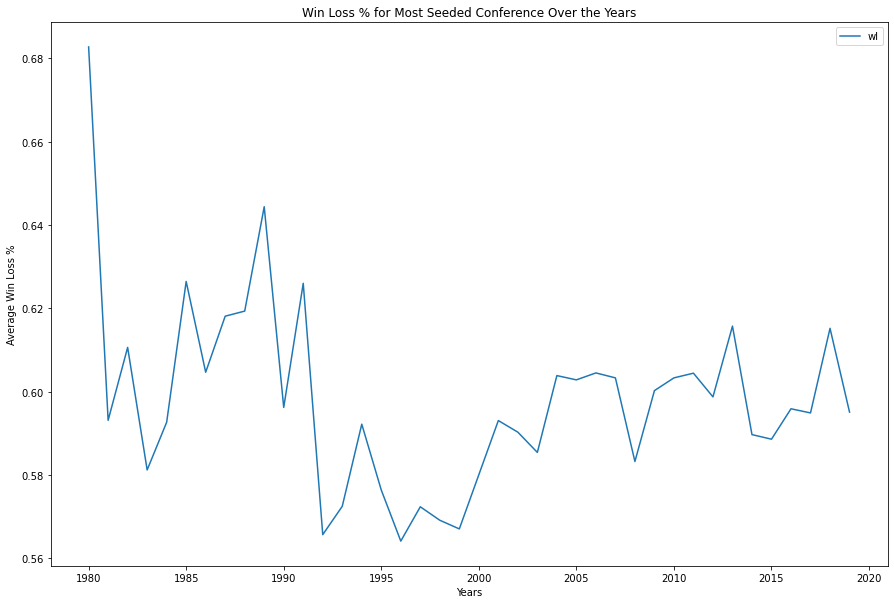

In [15]:
wl = dfline[['wl', 'year']]

graph4 = wl.groupby('year').mean() 
graph4.plot(kind='line', figsize=(15, 10))

plt.title("Win Loss % for Most Seeded Conference Over the Years")
plt.xlabel("Years")
plt.ylabel("Average Win Loss %")

#Below is the visualization for win loss percentage for the Big East over the years. We can see that the Big East has a very good average win loss percentage, never falling below .500. This means that the big East has always averaged out 
#to be a winning conference. This helps explain why the Big East is the most seeded conference in our data set. 

In [17]:
indexYears = line_graph_data[(line_graph_data['year'] == 1900)].index
line_graph_data.drop(indexYears , inplace=True)

#Getting rid of the outlier again, we believe this was a typo in the data set, so we are omitting it. 

Text(0, 0.5, 'Points Scored')

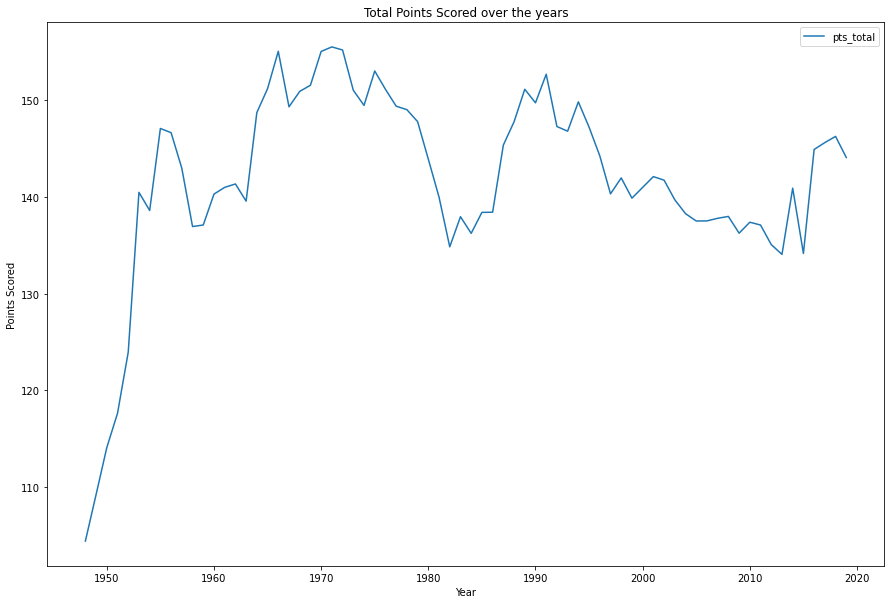

In [18]:
dataframe = line_graph_data[['pts_total', 'year']]
graph5 = dataframe.groupby('year').mean()

graph5.plot(kind='line', figsize=(15, 10))

plt.title("Total Points Scored over the years")
plt.xlabel("Year")
plt.ylabel("Points Scored")

#This visualization shows us the Total Points scored in the NCAA over the years that our data covers. We can see that points scored increases significantly from the 1940's into the 1970's, and then begins to descend into the 2020's. 
#1970 appears to have the highest value for points scored. There are a few possible explanations for the drastic increase in points scored in the early years of our data, which can include rule changes for the game of basketball, increased
#popularity for the game,among other factors. This visualization can be used to help us understand why splitting our data with early years as our training and later years as our test resulted in worse results than a random distribution of 
#data to our training and test sets. 

In [11]:
#ANOVA table
#We decided to run our anova test using conference and the win loss % data, grouping by the conference
#We then ran the anova test (f-value and p-value) on the data using the Big east, and Big 12 conferences, which will compare the means of each conferences win loss %


grouped_test2=dfTraining[['conf','wl']].groupby(['conf'])
f_val, p_val = stat.f_oneway(grouped_test2.get_group('Big East')['wl'], grouped_test2.get_group('Big 12')['wl'])  
print( "ANOVA results: F=", f_val, ", P =", p_val)  

#analyzing the results of the ANOVA, we have an F-value low at .14, which indicates that the conference ranking means are close together relative to their variability.
#The p-value tells a similar story. The p-value > .05, which indicates there is not enough evidence to reject the hypothesis that the means are all equal. 

print("This is correlation")
print(dfTraining.corr())
#We also ran a correlation table of our dfTraining data set using the .corr() function. 
#Analyzing this, we can see that overall our data has a pretty high correlation to eachother, the highest being .938191 between pts_diff & wl, and the lowest being .332308 between sos & wl
#From looking at this correlation table it appears most of the data have relatively strong correlation with eachother, which will help our model with predicting seeded based on the other attributes 

ANOVA results: F= 0.1418571044728123 , P = 0.7066389806044581
This is correlation
                   wl   wl_conf       srs       sos    seeded  is_ap_high  \
wl           1.000000  0.859914  0.767552  0.332308  0.594294    0.484997   
wl_conf      0.859914  1.000000  0.520658  0.058941  0.507565    0.333591   
srs          0.767552  0.520658  1.000000  0.818989  0.583598    0.625436   
sos          0.332308  0.058941  0.818989  1.000000  0.384557    0.527500   
seeded       0.594294  0.507565  0.583598  0.384557  1.000000    0.622228   
is_ap_high   0.484997  0.333591  0.625436  0.527500  0.622228    1.000000   
is_ap_final  0.447102  0.345813  0.518743  0.398787  0.566743    0.717546   
pts_diff     0.938191  0.773976  0.818649  0.376387  0.562066    0.500816   

             is_ap_final  pts_diff  
wl              0.447102  0.938191  
wl_conf         0.345813  0.773976  
srs             0.518743  0.818649  
sos             0.398787  0.376387  
seeded          0.566743  0.562066  
is

In [18]:
#Imports the test data and saves it in the dfTest variable
body = client_0e13c2cd05114f26ab7cc32b4518509d.get_object(Bucket='ds320-donotdelete-pr-egg8nb6d95qqxy',Key='Test.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dfTest = pd.read_csv(body)
dfTest.head()

,season,conf,w,l,wl,w_conf,l_conf,wl_conf,srs,sos,...,seed,coaches,seeded,year,is_ap_pre,is_ap_high,is_ap_final,pts_diff,school,pts_total
0,2018-19,Southland,27,6,0.818,14,4,0.778,-1.28,-8.10,...,15,Joe Golding,True,2019,False,False,False,11.4,abilene-christian,137.6
1,2017-18,Southland,16,16,0.500,8,10,0.444,-9.14,-6.82,...,20,Joe Golding,False,2018,False,False,False,2.5,abilene-christian,144.9
2,2016-17,Southland,13,16,0.448,7,11,0.389,-11.86,-7.10,...,20,Joe Golding,False,2017,False,False,False,-2.2,abilene-christian,140.8
3,2018-19,MWC,14,18,0.438,8,10,0.444,-3.93,0.59,...,20,Dave Pilipovich,False,2019,False,False,False,-3.6,air-force,139.8
4,2017-18,MWC,12,19,0.387,6,12,0.333,-4.31,1.72,...,20,Dave Pilipovich,False,2018,False,False,False,-3.9,air-force,140.9


In [19]:
#Drops unnecessary columns from dfTest
dfTest = dfTest.drop(columns=['season', 'w','l', 'w_conf','l_conf', 'pts', 'pts_vs', 'ap_pre','ap_high',
                         'ap_final','ncaa_tournament','seed','coaches','year','is_ap_pre',
                         'school','pts_total'])
dfTest.columns

Index(['conf', 'wl', 'wl_conf', 'srs', 'sos', 'seeded', 'is_ap_high',
       'is_ap_final', 'pts_diff'],
      dtype='object')

In [20]:
#Checks dfTest for missing values
dfTest.isnull().sum()

conf           0
wl             0
wl_conf        0
srs            0
sos            0
seeded         0
is_ap_high     0
is_ap_final    0
pts_diff       0
dtype: int64

In [21]:
#Describes dfTest
dfTest.describe(include='all')

,conf,wl,wl_conf,srs,sos,seeded,is_ap_high,is_ap_final,pts_diff
count,1055,1055.000000,1055.000000,1055.000000,1055.000000,1055,1055,1055,1055.000000
unique,32,NaN,NaN,NaN,NaN,2,2,2,NaN
top,ACC,NaN,NaN,NaN,NaN,False,False,False,NaN
freq,45,NaN,NaN,NaN,NaN,851,923,1005,NaN
mean,NaN,0.513321,0.500064,-0.516900,-0.231801,NaN,NaN,NaN,1.089573
std,NaN,0.171609,0.206556,10.428987,5.783891,NaN,NaN,NaN,6.218358
min,NaN,0.069000,0.000000,-26.990000,-12.480000,NaN,NaN,NaN,-23.100000
25%,NaN,0.394000,0.333000,-8.095000,-4.285000,NaN,NaN,NaN,-3.100000
50%,NaN,0.515000,0.500000,-1.580000,-1.640000,NaN,NaN,NaN,1.200000
75%,NaN,0.629000,0.667000,6.705000,3.610000,NaN,NaN,NaN,5.200000


In [22]:
#Displays info about dfTest
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   conf         1055 non-null   object 
 1   wl           1055 non-null   float64
 2   wl_conf      1055 non-null   float64
 3   srs          1055 non-null   float64
 4   sos          1055 non-null   float64
 5   seeded       1055 non-null   bool   
 6   is_ap_high   1055 non-null   bool   
 7   is_ap_final  1055 non-null   bool   
 8   pts_diff     1055 non-null   float64
dtypes: bool(3), float64(5), object(1)
memory usage: 52.7+ KB


In [20]:
#sorts dfTraining and dfTest by conf column
#removes conferences from dfTraining that do not exist in dfTest
#The removal of these 6 conferences should not impact the model in any meaningful way.
dfTraining = dfTraining.sort_values('conf')
dfTest = dfTest.sort_values('conf')
dfTraining = dfTraining[dfTraining['conf'] != 'GWC']
dfTraining = dfTraining[dfTraining['conf'] != 'Ind']
dfTraining = dfTraining[dfTraining['conf'] != 'MW Coll']
dfTraining = dfTraining[dfTraining['conf'] != 'Mid-Cont']
dfTraining = dfTraining[dfTraining['conf'] != 'Pac-10']
dfTraining = dfTraining[dfTraining['conf'] != 'TAAC']

In [21]:
#Displays conferences in dfTraining/dfTest to ensure they are the same.
confs = dfTraining.conf.unique()
confs.sort()
confs 

array(['A-10', 'A-Sun', 'AAC', 'ACC', 'AEC', 'Big 12', 'Big East',
       'Big Sky', 'Big South', 'Big Ten', 'Big West', 'CAA', 'CUSA',
       'Horizon', 'Ivy', 'MAAC', 'MAC', 'MEAC', 'MVC', 'MWC', 'NEC',
       'OVC', 'Pac-12', 'Patriot', 'SEC', 'SWAC', 'Southern', 'Southland',
       'Summit', 'Sun Belt', 'WAC', 'WCC'], dtype=object)

In [22]:
confs = dfTest.conf.unique()
confs.sort()
confs 

array(['A-10', 'A-Sun', 'AAC', 'ACC', 'AEC', 'Big 12', 'Big East',
       'Big Sky', 'Big South', 'Big Ten', 'Big West', 'CAA', 'CUSA',
       'Horizon', 'Ivy', 'MAAC', 'MAC', 'MEAC', 'MVC', 'MWC', 'NEC',
       'OVC', 'Pac-12', 'Patriot', 'SEC', 'SWAC', 'Southern', 'Southland',
       'Summit', 'Sun Belt', 'WAC', 'WCC'], dtype=object)

In [23]:
#OneHot encodes conferences in dfTraining and dfTest
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import *

confTraining = OneHotEncoder().fit_transform(dfTraining[['conf']]).toarray()
confTraining=pd.DataFrame(confTraining).astype(int)
confTest = OneHotEncoder().fit_transform(dfTest[['conf']]).toarray()
confTest=pd.DataFrame(confTest).astype(int)

In [24]:
#Renames columns
confTraining.columns = ['A-10', 'A-Sun', 'AAC', 'ACC', 'AEC', 'Big 12', 'Big East',
       'Big Sky', 'Big South', 'Big Ten', 'Big West', 'CAA', 'CUSA',
       'Horizon', 'Ivy', 'MAAC', 'MAC', 'MEAC', 'MVC', 'MWC', 'NEC',
       'OVC', 'Pac-12', 'Patriot', 'SEC', 'SWAC', 'Southern', 'Southland',
       'Summit', 'Sun Belt', 'WAC', 'WCC']
confTraining

,A-10,A-Sun,AAC,ACC,AEC,Big 12,Big East,Big Sky,Big South,Big Ten,...,Pac-12,Patriot,SEC,SWAC,Southern,Southland,Summit,Sun Belt,WAC,WCC
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
confTest.columns = ['A-10', 'A-Sun', 'AAC', 'ACC', 'AEC', 'Big 12', 'Big East',
       'Big Sky', 'Big South', 'Big Ten', 'Big West', 'CAA', 'CUSA',
       'Horizon', 'Ivy', 'MAAC', 'MAC', 'MEAC', 'MVC', 'MWC', 'NEC',
       'OVC', 'Pac-12', 'Patriot', 'SEC', 'SWAC', 'Southern', 'Southland',
       'Summit', 'Sun Belt', 'WAC', 'WCC']
confTest

,A-10,A-Sun,AAC,ACC,AEC,Big 12,Big East,Big Sky,Big South,Big Ten,...,Pac-12,Patriot,SEC,SWAC,Southern,Southland,Summit,Sun Belt,WAC,WCC
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
#We decided to use label encoding for our data columns which were True/False data as the label encoder is a bit more simple 
#the label encoder goes alphabetical and will assign 0 to False, and 1 to True, which works because true is more significant than False

from sklearn.preprocessing import LabelEncoder
#Importing the label encoder from sklearn

labelencoder_seed = LabelEncoder()
seedTraining = labelencoder_seed.fit_transform(dfTraining[['seeded']])
seedTraining = pd.DataFrame(seedTraining).astype(int)
seedTraining.columns = ["Made Tournament"]
#starting with the dfTraining seeded seried, we label encoded that column, set it into a df as type integer, and re-named the column
#followed same process for is_ap_high and is_ap_final

labelencoder_ap_high = LabelEncoder()
is_ap_highTraining = labelencoder_seed.fit_transform(dfTraining[['is_ap_high']])
is_ap_highTraining=pd.DataFrame(is_ap_highTraining).astype(int)
is_ap_highTraining.columns = ["is_ap_high"]

labelencoder_ap_final = LabelEncoder()
is_ap_finalTraining = labelencoder_seed.fit_transform(dfTraining[['is_ap_final']])
is_ap_finalTraining=pd.DataFrame(is_ap_finalTraining).astype(int)
is_ap_finalTraining.columns = ["is_ap_final"]

labelencoder_seed = LabelEncoder()
seedTest = labelencoder_seed.fit_transform(dfTest[['seeded']])
seedTest=pd.DataFrame(seedTest).astype(int)
seedTest.columns = ["Made Tournament"]
#Same process but with the test data

labelencoder_ap_high = LabelEncoder()
is_ap_highTest = labelencoder_seed.fit_transform(dfTest[['is_ap_high']])
is_ap_highTest=pd.DataFrame(is_ap_highTest).astype(int)
is_ap_highTest.columns = ["is_ap_high"]

labelencoder_ap_final = LabelEncoder()
is_ap_finalTest = labelencoder_seed.fit_transform(dfTest[['is_ap_final']])
is_ap_finalTest=pd.DataFrame(is_ap_finalTest).astype(int)
is_ap_finalTest.columns = ["is_ap_final"]

In [28]:
dfTraining.columns

Index(['conf', 'wl', 'wl_conf', 'srs', 'sos', 'seeded', 'is_ap_high',
       'is_ap_final', 'pts_diff'],
      dtype='object')

In [29]:
#Drops redundant columns
dfTraining = dfTraining.drop(columns=['conf','seeded','is_ap_high','is_ap_final'])
dfTest = dfTest.drop(columns=['conf','seeded','is_ap_high','is_ap_final'])


In [30]:
#Resets indexes for columns to fix an error we were getting
confTraining.reset_index(drop=True, inplace=True)
is_ap_highTraining.reset_index(drop=True, inplace=True)
is_ap_finalTraining.reset_index(drop=True, inplace=True)
dfTraining.reset_index(drop=True, inplace=True)
#Concatenates columns together to create oneTrainingDF and oneTestDF
oneTrainingDF=pd.concat([confTraining, is_ap_highTraining, is_ap_finalTraining, dfTraining], axis=1)
oneTestDF=pd.concat([confTest, is_ap_highTest, is_ap_finalTest, dfTest], axis=1)

In [31]:
#Applies Tree based classifier on the full Training dataset
#Applies model to Test data

from sklearn import tree
from sklearn import metrics
clf = tree.DecisionTreeClassifier()
clf = clf.fit(oneTrainingDF, seedTraining)
y_predict=clf.predict(oneTestDF)
print("Training set Accuracy: ", metrics.accuracy_score(seedTraining, clf.predict(oneTrainingDF)))
print("Test set Accuracy: ", metrics.accuracy_score(seedTest, y_predict))

Training set Accuracy:  1.0
Test set Accuracy:  0.6720379146919432


In [38]:
#Applies KNN Classifier to Training data
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(oneTrainingDF,seedTraining)
neigh




/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


KNeighborsClassifier(n_neighbors=4)

In [39]:
#Uses KNN model on Test data
yhat = neigh.predict(oneTestDF)
yhat[0:5]
print("Training set Accuracy: ", metrics.accuracy_score(seedTraining, neigh.predict(oneTrainingDF)))
print("Test set Accuracy: ", metrics.accuracy_score(seedTest, yhat))

Training set Accuracy:  0.9209393346379647
Test set Accuracy:  0.7127962085308057


In [40]:
#Prints confusion matrix for the KNN model test
labels=[0,1]
cm=confusion_matrix(seedTest,yhat,labels)
print(cm)

[[725 126]
 [177  27]]


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [43]:
#Applies random data sampling to Predictors/Class with (80:20) ratio
#only uses the Training data
#Runs both tree-based and KNN classifier models. 
#Also prints confusion matrix for the KNN model test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(oneTrainingDF, seedTraining, test_size=0.2, random_state=4)
print ('Training set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
y_predict=clf.predict(X_test)
print("Training set Accuracy: ", metrics.accuracy_score(Y_train, clf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, y_predict))
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
yhat = neigh.predict(X_test)
yhat[0:5]
print("Training set Accuracy: ", metrics.accuracy_score(Y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, yhat))
labels=[0,1]
cm=confusion_matrix(Y_test,yhat,labels)
print(cm)

Training set: (4088, 39) (4088, 1)
Test set: (1022, 39) (1022, 1)
Training set Accuracy:  1.0
Test set Accuracy:  0.8835616438356164


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Training set Accuracy:  0.9195205479452054
Test set Accuracy:  0.9021526418786693
[[804  21]
 [ 79 118]]


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
